# References
- [Handling imbalanced data (kdnuggets)](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html)
- [Resampling strategies for imbalanced datasets (Kaggle)](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets)
- [Handling Imbalanced Data (TensorFlow)](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

# Import modules

In [1]:
# For data processing
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sb
plt.style.use('fivethirtyeight') 

# For data splitting
from sklearn.model_selection import train_test_split

# For handling imbalanced dataset
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Data Splitting

In [2]:
# Select several columns
cols = ['popularity', 'original_language', 'casts_popularity_sum',
        'crews_popularity_sum', 'genres', 'decade_released', 
        'budget', 'revenue', 'vote_count', 'vote_average']

df = pd.read_csv('cleaned-movie-dataset.csv', index_col=0)[cols]

# Create a new column 'in_en', 1 if the original language is in English and 0 otherwise
df['in_en'] = (df['original_language'] == 'en').astype('int64')

df = df.drop(columns=['original_language'])

# Rearrange columns
df = df[['popularity', 'casts_popularity_sum', 'crews_popularity_sum', 
         'budget', 'decade_released', 'genres', 
         'revenue', 'vote_count', 'vote_average']]

df.head()

,popularity,casts_popularity_sum,crews_popularity_sum,budget,decade_released,genres,revenue,vote_count,vote_average
0,283.822,755.450,473.269,356000000.0,2010s,"['Adventure', 'Science Fiction', 'Action']",2.797801e+09,17799,8.3
1,102.112,108.804,878.826,237000000.0,2000s,"['Action', 'Adventure', 'Fantasy', 'Science Fi...",2.787965e+09,23178,7.5
2,86.808,201.581,122.649,200000000.0,1990s,"['Drama', 'Romance']",2.187464e+09,18982,7.9
3,53.930,391.303,235.947,245000000.0,2010s,"['Action', 'Adventure', 'Science Fiction', 'Fa...",2.068224e+09,15675,7.4
4,299.524,528.712,501.005,300000000.0,2010s,"['Adventure', 'Action', 'Science Fiction']",2.046240e+09,21489,8.3


In [3]:
# Split the DF into predictors and response
X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Define good as vote_average >= 7.2 (80% percentile)
y = (y >= 7.2).astype('int64')

# Split the dataset into 70% train and 30% test set
# Set random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=20)

In [4]:
print("Good vs Not Good Movies Train Set Proportion")
print(y_train.value_counts()[1], ':', y_train.value_counts()[0])

Good vs Not Good Movies Train Set Proportion
1018 : 3931


In [5]:
train_df = pd.concat([X_train, y_train], axis=1).rename(columns={'vote_average': 'is_good'})
train_df.head()

,popularity,casts_popularity_sum,crews_popularity_sum,budget,decade_released,genres,revenue,vote_count,is_good
5527,1.680,34.059,8.671,3300000.0,2010s,"['Comedy', 'Action', 'Drama']",10000000.0,8,0
3263,18.013,46.018,9.456,26000000.0,2010s,"['Thriller', 'Adventure', 'Mystery', 'Fantasy'...",34592118.0,200,0
1022,17.237,182.113,198.986,65000000.0,2000s,"['Drama', 'History', 'Thriller']",163247198.0,1122,0
4603,11.931,110.585,44.527,20000000.0,2000s,"['Action', 'Drama', 'Thriller']",16605763.0,129,0
2733,14.717,99.835,75.898,51000000.0,2000s,"['Comedy', 'Family']",47231070.0,405,0


In [6]:
# train_df.to_csv('train.csv')

## Random Oversampling on training data

In [7]:
# Define oversampling strategy (creates 1:2 ratio)
over_smp = RandomOverSampler(sampling_strategy=0.5, random_state=20)

# Fit and apply the transform
X_res, y_res = over_smp.fit_resample(X_train, y_train)

In [8]:
print("Good vs Not Good Movies Train Set Proportion (After oversampling)")
print(y_res.value_counts()[1], ':', y_res.value_counts()[0])

Good vs Not Good Movies Train Set Proportion (After oversampling)
1965 : 3931


In [9]:
# Combine the X and y to a single DF and rename column
oversampled_train_df = pd.concat([X_res, y_res], axis=1).rename(columns={'vote_average': 'is_good'})
oversampled_train_df.head()

,popularity,casts_popularity_sum,crews_popularity_sum,budget,decade_released,genres,revenue,vote_count,is_good
0,1.680,34.059,8.671,3300000.0,2010s,"['Comedy', 'Action', 'Drama']",10000000.0,8,0
1,18.013,46.018,9.456,26000000.0,2010s,"['Thriller', 'Adventure', 'Mystery', 'Fantasy'...",34592118.0,200,0
2,17.237,182.113,198.986,65000000.0,2000s,"['Drama', 'History', 'Thriller']",163247198.0,1122,0
3,11.931,110.585,44.527,20000000.0,2000s,"['Action', 'Drama', 'Thriller']",16605763.0,129,0
4,14.717,99.835,75.898,51000000.0,2000s,"['Comedy', 'Family']",47231070.0,405,0


In [10]:
# Save as csv
# oversampled_train_df.to_csv('oversampled-train.csv')

## SMOTETomek Resampling on training data
This only applies for numerical variables.

In [11]:
# Select numerical variables only
X_train = X_train[['popularity', 'casts_popularity_sum',
                   'crews_popularity_sum', 'budget',
                   'revenue', 'vote_count']]
X_train.head()

,popularity,casts_popularity_sum,crews_popularity_sum,budget,revenue,vote_count
5527,1.680,34.059,8.671,3300000.0,10000000.0,8
3263,18.013,46.018,9.456,26000000.0,34592118.0,200
1022,17.237,182.113,198.986,65000000.0,163247198.0,1122
4603,11.931,110.585,44.527,20000000.0,16605763.0,129
2733,14.717,99.835,75.898,51000000.0,47231070.0,405


In [12]:
# Set random_state for reproducibility
smt = SMOTETomek(random_state=20)
X_res, y_res = smt.fit_resample(X_train, y_train)

In [13]:
print("Good vs Not Good Movies Train Set Proportion (After SMOTETomek resampling)")
print(y_res.value_counts()[1], ':', y_res.value_counts()[0])

Good vs Not Good Movies Train Set Proportion (After SMOTETomek resampling)
3431 : 3431


In [14]:
# Combine the X and y to a single DF and rename column
smotetomek_train_df = pd.concat([X_res, y_res], axis=1).rename(columns={'vote_average': 'is_good'})
smotetomek_train_df.head()

,popularity,casts_popularity_sum,crews_popularity_sum,budget,revenue,vote_count,is_good
0,1.680,34.059,8.671,3300000.0,10000000.0,8,0
1,18.013,46.018,9.456,26000000.0,34592118.0,200,0
2,11.931,110.585,44.527,20000000.0,16605763.0,129,0
3,14.717,99.835,75.898,51000000.0,47231070.0,405,0
4,23.357,99.896,62.278,32000000.0,83615414.0,897,0


In [15]:
# Save as csv
# smotetomek_train_df.to_csv('smotetomek-train.csv')

## SMOTEENN Resampling on training data
Similar with SMOTETomek resampling, this only applies for numerical variables.

In [16]:
X_train = X_train[['popularity', 'casts_popularity_sum',
                   'crews_popularity_sum', 'budget',
                   'revenue', 'vote_count']]
X_train.head()

,popularity,casts_popularity_sum,crews_popularity_sum,budget,revenue,vote_count
5527,1.680,34.059,8.671,3300000.0,10000000.0,8
3263,18.013,46.018,9.456,26000000.0,34592118.0,200
1022,17.237,182.113,198.986,65000000.0,163247198.0,1122
4603,11.931,110.585,44.527,20000000.0,16605763.0,129
2733,14.717,99.835,75.898,51000000.0,47231070.0,405


In [17]:
# Set random_state for reproducibility
sme = SMOTEENN(random_state=20)
X_res, y_res = sme.fit_resample(X_train, y_train)

In [18]:
print("Good vs Not Good Movies Train Set Proportion (After SMOTEENN resampling)")
print(y_res.value_counts()[1], ':', y_res.value_counts()[0])

Good vs Not Good Movies Train Set Proportion (After SMOTEENN resampling)
1939 : 1756


In [19]:
# Combine the X and y to a single DF and rename column
smoteenn_train_df = pd.concat([X_res, y_res], axis=1).rename(columns={'vote_average': 'is_good'})
smoteenn_train_df.head()

,popularity,casts_popularity_sum,crews_popularity_sum,budget,revenue,vote_count,is_good
0,1.680,34.059,8.671,3300000.0,10000000.0,8,0
1,11.931,110.585,44.527,20000000.0,16605763.0,129,0
2,14.717,99.835,75.898,51000000.0,47231070.0,405,0
3,12.050,33.433,10.263,17500000.0,25024919.0,380,0
4,7.503,36.672,13.520,160000.0,4000000.0,51,0


In [20]:
# Save as csv
# smoteenn_train_df.to_csv('smoteenn-train.csv')

# Save test data as csv

In [21]:
# Combine the X and y to a single DF and rename column
test_df = pd.concat([X_test, y_test], axis=1).rename(columns={'vote_average': 'is_good'})
test_df.head()

,popularity,casts_popularity_sum,crews_popularity_sum,budget,decade_released,genres,revenue,vote_count,is_good
6183,10.639,53.101,21.680,5800000.0,2000s,"['Action', 'Adventure', 'Drama']",7000000.0,28,0
786,48.052,100.519,97.495,60000000.0,2010s,"['Action', 'Thriller']",205754447.0,3573,0
100,37.487,255.221,181.062,170000000.0,2010s,"['Action', 'Science Fiction', 'Adventure']",772776600.0,22271,1
4763,19.589,83.531,99.984,80000000.0,2000s,"['Science Fiction', 'Thriller', 'Mystery']",15071514.0,989,0
429,27.201,121.827,136.950,40000000.0,1980s,"['Adventure', 'Comedy', 'Family', 'Science Fic...",332000000.0,9474,1


In [22]:
# Save as csv
# test_df.to_csv('test.csv')

# Visualisation of resampled data

In [23]:
oversampled_train_df = pd.read_csv('oversampled-train.csv',index_col= 0)
smoteenn_train_df = pd.read_csv('smoteenn-train.csv',index_col= 0)
smotetomek_train_df = pd.read_csv('smotetomek-train.csv',index_col= 0)
train_df = pd.read_csv('train.csv',index_col=0)

Text(0.5, 0, 'is_good - SMOTEENN resampling')

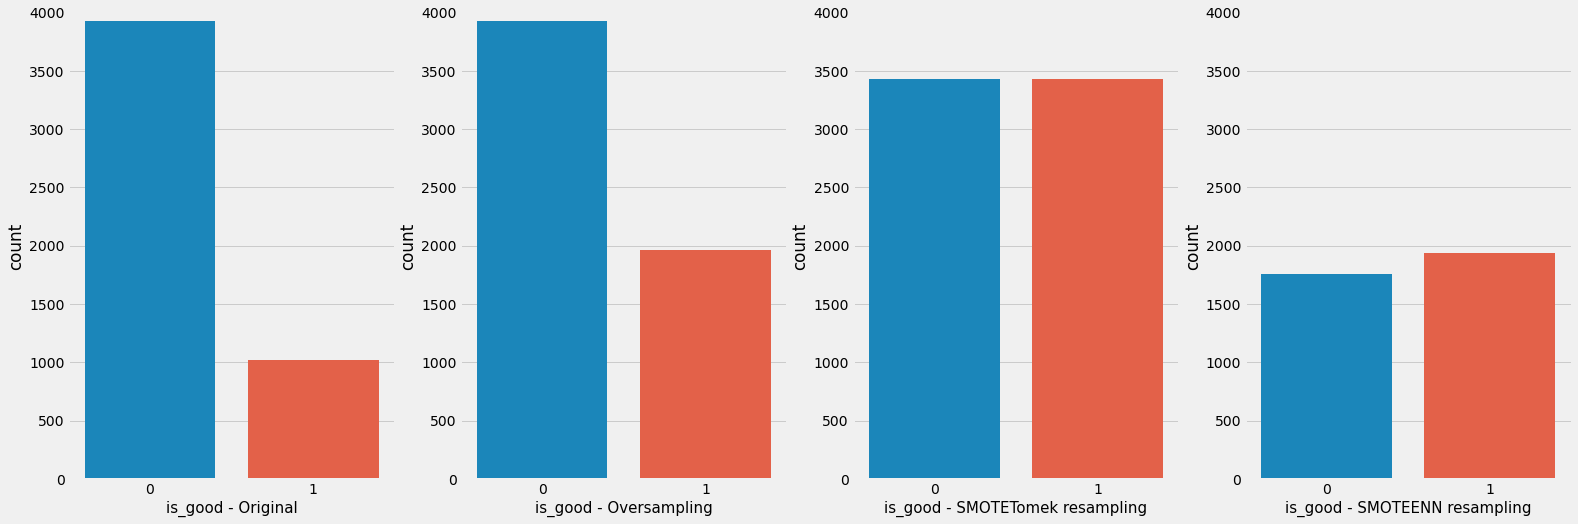

In [47]:
fig, axes =plt.subplots(1,4,figsize=(24,8))
plt.setp(axes,ylim=(0,4000))
sb.countplot(x=train_df['is_good'], ax=axes[0])
ax = axes[0]
ax.set_xlabel("is_good - Original",fontsize=15)
sb.countplot(x=oversampled_train_df['is_good'], ax=axes[1])
ax = axes[1]
ax.set_xlabel("is_good - Oversampling",fontsize=15)
sb.countplot(x=smotetomek_train_df['is_good'], ax=axes[2])
ax = axes[2]
ax.set_xlabel("is_good - SMOTETomek resampling",fontsize=15)
sb.countplot(x=smoteenn_train_df['is_good'], ax=axes[3])
ax = axes[3]
ax.set_xlabel("is_good - SMOTEENN resampling",fontsize=15)

Therefore, we can now see that the ratio between good vs not good movies is more balanced with the resampled data vs the original data.